In [1]:
# 本代码由可视化策略环境自动生成 2019年5月5日 13:48
# 本代码单元只能在可视化模式下编辑。您也可以拷贝代码，粘贴到新建的代码单元或者策略，然后修改。


# 回测引擎：每日数据处理函数，每天执行一次
def m19_handle_data_bigquant_run(context, data):
    # 按日期过滤得到今日的预测数据
    ranker_prediction = context.ranker_prediction[
        context.ranker_prediction.date == data.current_dt.strftime('%Y-%m-%d')]

    # 1. 资金分配
    # 平均持仓时间是hold_days，每日都将买入股票，每日预期使用 1/hold_days 的资金
    # 实际操作中，会存在一定的买入误差，所以在前hold_days天，等量使用资金；之后，尽量使用剩余资金（这里设置最多用等量的1.5倍）
    is_staging = context.trading_day_index < context.options['hold_days'] # 是否在建仓期间（前 hold_days 天）
    cash_avg = context.portfolio.portfolio_value / context.options['hold_days']
    cash_for_buy = min(context.portfolio.cash, (1 if is_staging else 1.5) * cash_avg)
    cash_for_sell = cash_avg - (context.portfolio.cash - cash_for_buy)
    positions = {e.symbol: p.amount * p.last_sale_price
                 for e, p in context.portfolio.positions.items()}

    # 2. 生成卖出订单：hold_days天之后才开始卖出；对持仓的股票，按机器学习算法预测的排序末位淘汰
    if not is_staging and cash_for_sell > 0:
        equities = {e.symbol: e for e, p in context.portfolio.positions.items()}
        instruments = list(reversed(list(ranker_prediction.instrument[ranker_prediction.instrument.apply(
                lambda x: x in equities)])))

        for instrument in instruments:
            context.order_target(context.symbol(instrument), 0)
            cash_for_sell -= positions[instrument]
            if cash_for_sell <= 0:
                break

    # 3. 生成买入订单：按机器学习算法预测的排序，买入前面的stock_count只股票
    buy_cash_weights = context.stock_weights
    buy_instruments = list(ranker_prediction.instrument[:len(buy_cash_weights)])
    max_cash_per_instrument = context.portfolio.portfolio_value * context.max_cash_per_instrument
    for i, instrument in enumerate(buy_instruments):
        cash = cash_for_buy * buy_cash_weights[i]
        if cash > max_cash_per_instrument - positions.get(instrument, 0):
            # 确保股票持仓量不会超过每次股票最大的占用资金量
            cash = max_cash_per_instrument - positions.get(instrument, 0)
        if cash > 0:
            context.order_value(context.symbol(instrument), cash)

# 回测引擎：准备数据，只执行一次
def m19_prepare_bigquant_run(context):
    pass

# 回测引擎：初始化函数，只执行一次
def m19_initialize_bigquant_run(context):
    # 加载预测数据
    context.ranker_prediction = context.options['data'].read_df()

    # 系统已经设置了默认的交易手续费和滑点，要修改手续费可使用如下函数
    context.set_commission(PerOrder(buy_cost=0.0003, sell_cost=0.0013, min_cost=5))
    # 预测数据，通过options传入进来，使用 read_df 函数，加载到内存 (DataFrame)
    # 设置买入的股票数量，这里买入预测股票列表排名靠前的5只
    stock_count = 5
    # 每只的股票的权重，如下的权重分配会使得靠前的股票分配多一点的资金，[0.339160, 0.213986, 0.169580, ..]
    context.stock_weights = T.norm([1 / math.log(i + 2) for i in range(0, stock_count)])
    # 设置每只股票占用的最大资金比例
    context.max_cash_per_instrument = 0.2
    context.options['hold_days'] = 5


m1 = M.instruments.v2(
    start_date='2010-01-01',
    end_date='2015-01-01',
    market='CN_STOCK_A',
    instrument_list='',
    max_count=0
)

m2 = M.advanced_auto_labeler.v2(
    instruments=m1.data,
    label_expr="""# #号开始的表示注释
# 0. 每行一个，顺序执行，从第二个开始，可以使用label字段
# 1. 可用数据字段见 https://bigquant.com/docs/develop/datasource/deprecated/history_data.html
#   添加benchmark_前缀，可使用对应的benchmark数据
# 2. 可用操作符和函数见 `表达式引擎 <https://bigquant.com/docs/develop/bigexpr/usage.html>`_

# 计算收益：5日收盘价(作为卖出价格)除以明日开盘价(作为买入价格)
shift(close, -5) / shift(open, -1)

# 极值处理：用1%和99%分位的值做clip
clip(label, all_quantile(label, 0.01), all_quantile(label, 0.99))

# 将分数映射到分类，这里使用20个分类
all_wbins(label, 20)

# 过滤掉一字涨停的情况 (设置label为NaN，在后续处理和训练中会忽略NaN的label)
where(shift(high, -1) == shift(low, -1), NaN, label)
""",
    start_date='',
    end_date='',
    benchmark='000300.SHA',
    drop_na_label=True,
    cast_label_int=True
)

m3 = M.input_features.v1(
    features="""# #号开始的表示注释
# 多个特征，每行一个，可以包含基础特征和衍生特征
return_5
return_10
return_20
avg_amount_0/avg_amount_5
avg_amount_5/avg_amount_20
rank_avg_amount_0/rank_avg_amount_5
rank_avg_amount_5/rank_avg_amount_10
rank_return_0
rank_return_5
rank_return_10
rank_return_0/rank_return_5
rank_return_5/rank_return_10
pe_ttm_0
"""
)

m15 = M.general_feature_extractor.v7(
    instruments=m1.data,
    features=m3.data,
    start_date='',
    end_date='',
    before_start_days=0
)

m16 = M.derived_feature_extractor.v3(
    input_data=m15.data,
    features=m3.data,
    date_col='date',
    instrument_col='instrument',
    drop_na=False,
    remove_extra_columns=False
)

m7 = M.join.v3(
    data1=m2.data,
    data2=m16.data,
    on='date,instrument',
    how='inner',
    sort=False
)

m13 = M.dropnan.v1(
    input_data=m7.data
)

m6 = M.stock_ranker_train.v5(
    training_ds=m13.data,
    features=m3.data,
    learning_algorithm='排序',
    number_of_leaves=30,
    minimum_docs_per_leaf=1000,
    number_of_trees=20,
    learning_rate=0.1,
    max_bins=1023,
    feature_fraction=1,
    m_lazy_run=False
)

m9 = M.instruments.v2(
    start_date=T.live_run_param('trading_date', '2015-01-01'),
    end_date=T.live_run_param('trading_date', '2017-01-01'),
    market='CN_STOCK_A',
    instrument_list='',
    max_count=0
)

m17 = M.general_feature_extractor.v7(
    instruments=m9.data,
    features=m3.data,
    start_date='',
    end_date='',
    before_start_days=0
)

m18 = M.derived_feature_extractor.v3(
    input_data=m17.data,
    features=m3.data,
    date_col='date',
    instrument_col='instrument',
    drop_na=False,
    remove_extra_columns=False
)

m14 = M.dropnan.v1(
    input_data=m18.data
)

m8 = M.stock_ranker_predict.v5(
    model=m6.model,
    data=m14.data,
    m_lazy_run=False
)

m19 = M.trade.v4(
    instruments=m9.data,
    options_data=m8.predictions,
    start_date='',
    end_date='',
    handle_data=m19_handle_data_bigquant_run,
    prepare=m19_prepare_bigquant_run,
    initialize=m19_initialize_bigquant_run,
    volume_limit=0.025,
    order_price_field_buy='open',
    order_price_field_sell='close',
    capital_base=1000000,
    auto_cancel_non_tradable_orders=True,
    data_frequency='daily',
    price_type='后复权',
    product_type='股票',
    plot_charts=True,
    backtest_only=False,
    benchmark='000300.SHA'
)


[2019-05-05 13:39:45.675667] INFO: bigquant: instruments.v2 开始运行..

[2019-05-05 13:39:45.739289] INFO: bigquant: 命中缓存

[2019-05-05 13:39:45.741354] INFO: bigquant: instruments.v2 运行完成[0.065676s].

[2019-05-05 13:39:45.745592] INFO: bigquant: advanced_auto_labeler.v2 开始运行..

[2019-05-05 13:39:45.814721] INFO: bigquant: 命中缓存

[2019-05-05 13:39:45.818639] INFO: bigquant: advanced_auto_labeler.v2 运行完成[0.073034s].

[2019-05-05 13:39:45.822292] INFO: bigquant: input_features.v1 开始运行..

[2019-05-05 13:39:45.875507] INFO: bigquant: 命中缓存

[2019-05-05 13:39:45.877833] INFO: bigquant: input_features.v1 运行完成[0.055526s].

[2019-05-05 13:39:45.961447] INFO: bigquant: general_feature_extractor.v7 开始运行..

[2019-05-05 13:39:46.000505] INFO: bigquant: 命中缓存

[2019-05-05 13:39:46.002251] INFO: bigquant: general_feature_extractor.v7 运行完成[0.040813s].

[2019-05-05 13:39:46.006606] INFO: bigquant: derived_feature_extractor.v3 开始运行..

[2019-05-05 13:39:46.042411] INFO: bigquant: 命中缓存

[2019-05-05 13:39:46.046043] INFO: bigquant: derived_feature_extractor.v3 运行完成[0.039402s].

[2019-05-05 13:39:46.057828] INFO: bigquant: join.v3 开始运行..

[2019-05-05 13:39:46.100786] INFO: bigquant: 命中缓存

[2019-05-05 13:39:46.103369] INFO: bigquant: join.v3 运行完成[0.04553s].

[2019-05-05 13:39:46.108177] INFO: bigquant: dropnan.v1 开始运行..

[2019-05-05 13:39:46.196830] INFO: bigquant: 命中缓存

[2019-05-05 13:39:46.199687] INFO: bigquant: dropnan.v1 运行完成[0.091499s].

[2019-05-05 13:39:46.204406] INFO: bigquant: stock_ranker_train.v5 开始运行..

[2019-05-05 13:39:46.299647] INFO: bigquant: 命中缓存

[2019-05-05 13:39:47.742084] INFO: bigquant: stock_ranker_train.v5 运行完成[1.53766s].

[2019-05-05 13:39:47.746671] INFO: bigquant: instruments.v2 开始运行..

[2019-05-05 13:39:47.813014] INFO: bigquant: 命中缓存

[2019-05-05 13:39:47.815339] INFO: bigquant: instruments.v2 运行完成[0.068646s].

[2019-05-05 13:39:48.033274] INFO: bigquant: general_feature_extractor.v7 开始运行..

[2019-05-05 13:39:48.084009] INFO: bigquant: 命中缓存

[2019-05-05 13:39:48.086651] INFO: bigquant: general_feature_extractor.v7 运行完成[0.053373s].

[2019-05-05 13:39:48.093318] INFO: bigquant: derived_feature_extractor.v3 开始运行..

[2019-05-05 13:39:48.196585] INFO: bigquant: 命中缓存

[2019-05-05 13:39:48.198495] INFO: bigquant: derived_feature_extractor.v3 运行完成[0.105166s].

[2019-05-05 13:39:48.202037] INFO: bigquant: dropnan.v1 开始运行..

[2019-05-05 13:39:48.267318] INFO: bigquant: 命中缓存

[2019-05-05 13:39:48.269588] INFO: bigquant: dropnan.v1 运行完成[0.067539s].

[2019-05-05 13:39:48.274029] INFO: bigquant: stock_ranker_predict.v5 开始运行..

[2019-05-05 13:39:48.335678] INFO: bigquant: 命中缓存

[2019-05-05 13:39:48.338612] INFO: bigquant: stock_ranker_predict.v5 运行完成[0.064567s].

[2019-05-05 13:39:48.444458] INFO: bigquant: backtest.v8 开始运行..

[2019-05-05 13:39:48.739623] INFO: bigquant: 命中缓存

[2019-05-05 13:39:51.291684] INFO: bigquant: backtest.v8 运行完成[2.847187s].

In [2]:
# 收益分析
m19.factor_profit_analyze()

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Entire data start date: 2015-01-05
Entire data end date: 2016-12-30


Backtest Months: 23


Performance statistics,Backtest
cum_returns_final,3.22
annual_return,1.10
annual_volatility,0.43
sharpe_ratio,1.95
calmar_ratio,2.41
stability_of_timeseries,0.69
max_drawdown,-0.46
omega_ratio,1.40
sortino_ratio,2.73
skew,-0.74


Worst Drawdown Periods,net drawdown in %,peak date,valley date,recovery date,duration
0,45.84,2015-06-12,2015-09-15,2016-09-05,322
1,6.26,2015-05-27,2015-05-28,2015-06-02,5
2,5.18,2015-05-04,2015-05-07,2015-05-11,6
3,5.08,2015-02-03,2015-02-09,2015-02-16,10
4,4.56,2016-11-17,2016-12-14,2016-12-22,26




[-0.051 -0.119]


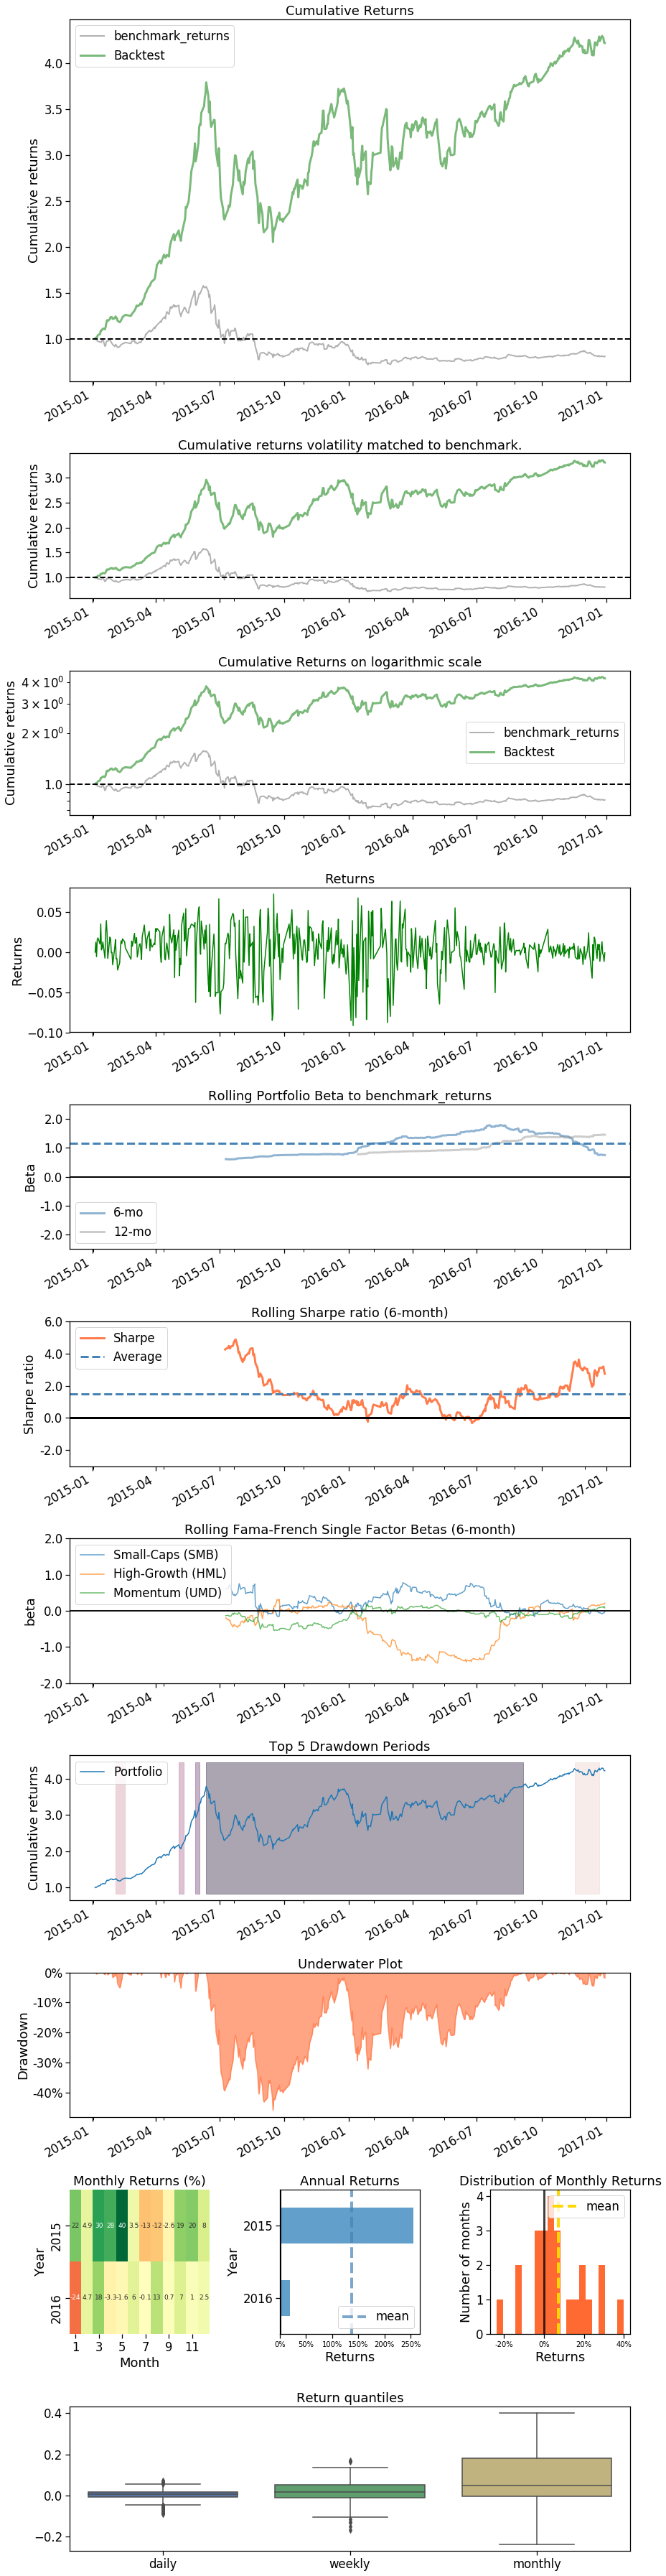

Stress Events,mean,min,max
Fall2015,-0.77%,-8.50%,7.25%
New Normal,0.33%,-9.15%,7.25%


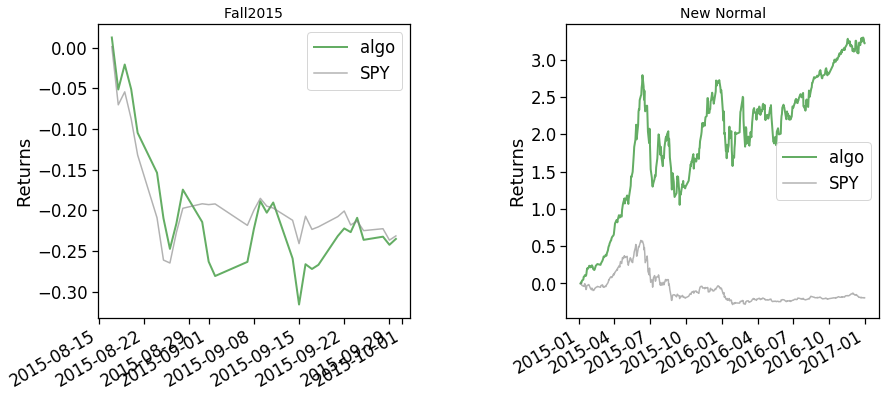

Top 10 long positions of all time,max
Equity(2966 [600556.SHA]),22.03%
Equity(2852 [300372.SZA]),21.88%
Equity(857 [002326.SZA]),21.53%
Equity(2361 [300135.SZA]),21.38%
Equity(459 [300380.SZA]),21.28%
Equity(1532 [300028.SZA]),21.16%
Equity(1209 [600153.SHA]),21.13%
Equity(1662 [002240.SZA]),21.11%
Equity(1217 [300094.SZA]),20.95%
Equity(574 [600654.SHA]),20.92%


Top 10 short positions of all time,max


Top 10 positions of all time,max
Equity(2966 [600556.SHA]),22.03%
Equity(2852 [300372.SZA]),21.88%
Equity(857 [002326.SZA]),21.53%
Equity(2361 [300135.SZA]),21.38%
Equity(459 [300380.SZA]),21.28%
Equity(1532 [300028.SZA]),21.16%
Equity(1209 [600153.SHA]),21.13%
Equity(1662 [002240.SZA]),21.11%
Equity(1217 [300094.SZA]),20.95%
Equity(574 [600654.SHA]),20.92%


All positions ever held,max
Equity(2966 [600556.SHA]),22.03%
Equity(2852 [300372.SZA]),21.88%
Equity(857 [002326.SZA]),21.53%
Equity(2361 [300135.SZA]),21.38%
Equity(459 [300380.SZA]),21.28%
Equity(1532 [300028.SZA]),21.16%
Equity(1209 [600153.SHA]),21.13%
Equity(1662 [002240.SZA]),21.11%
Equity(1217 [300094.SZA]),20.95%
Equity(574 [600654.SHA]),20.92%


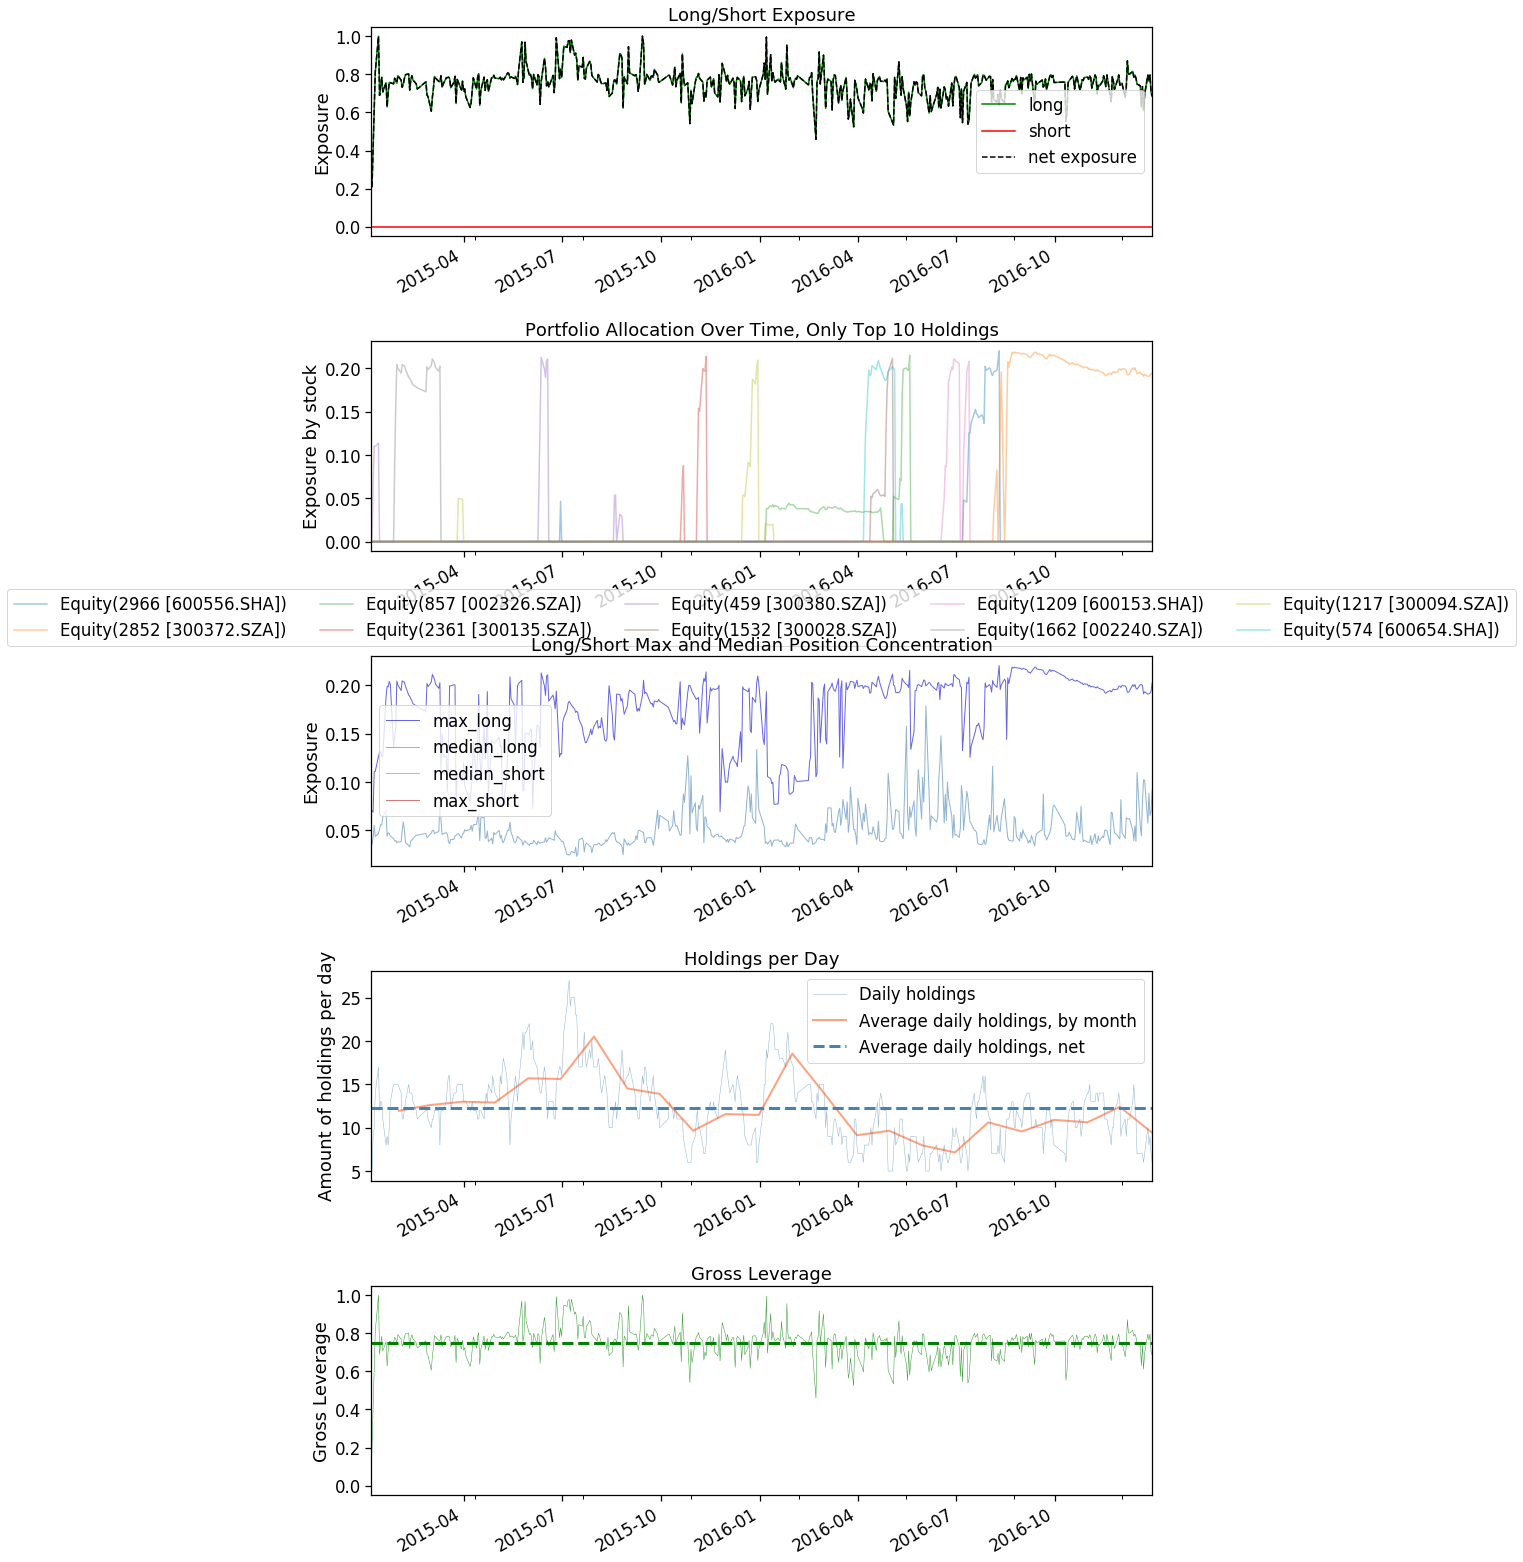

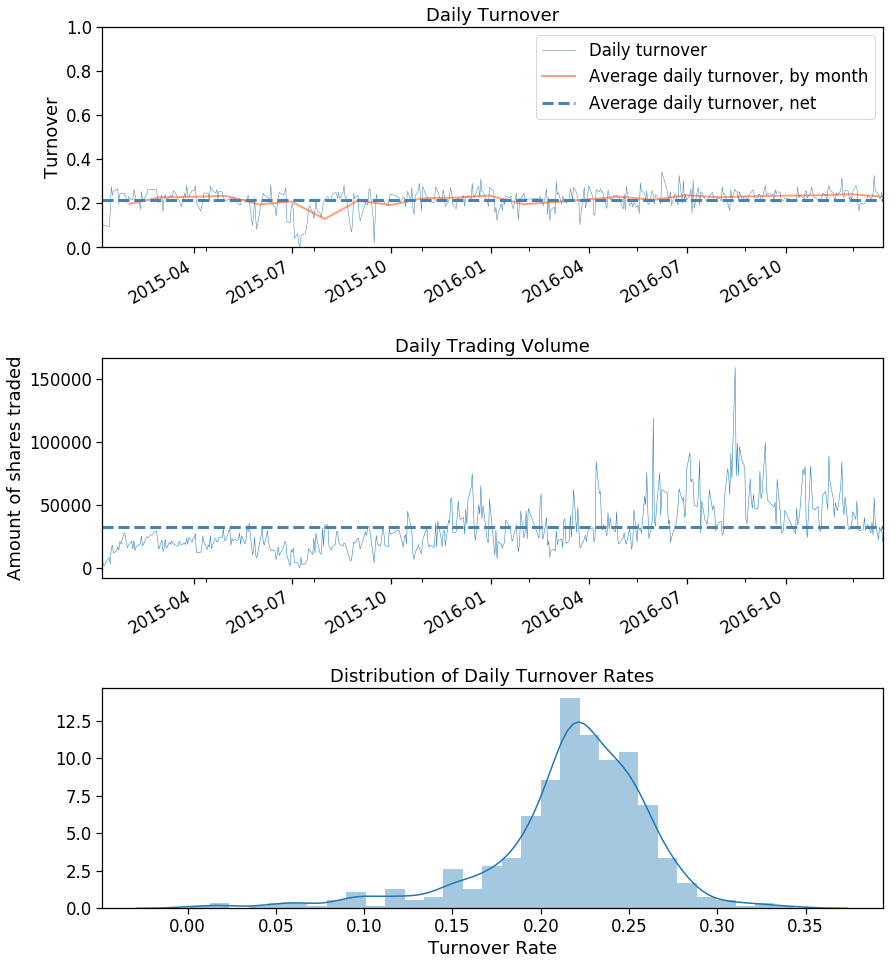

In [3]:
# 风险分析
m19.pyfolio_full_tear_sheet() 